# Dealing with Problems with Uncertainty
Author: Jin Yeom (jinyeom@utexas.edu)

In this notebook, we're going to explore AI methods based on the probability theory for solving problems with uncertainty. We'll first look at Bayesian Networks (or Belief Networks), Hidden Markov Models (HMMs), then finally Decision Networks. **Note**: this notebook is based on Dr. Scott Niekum's lecture on Artificial Intelligence (CS343) from the University of Texas at Austin. **Also note**: this notebook will assume some knowledge in the probability theory, and will not go over details in basic probability.

## Bayesian Network
As the name suggests, the Bayesian network (BNs, or sometimes called belief network or Bayes nets) is based on Bayes' rule:

$$P(X|Y) = \frac{P(Y|X)P(X)}{P(Y)}$$

where $X$ and $Y$ are both random variables. It is also called a network, due to its representation, i.e., all the possible events are represented as nodes in a directed acyclic graph with their likelihoods, and are connected with each other based on assumed direct influences, or **conditional dependences**. Essentially, the network altogether models some part of the real world.

Bayes nets are composed of the topology of the network, which is often designed by hand, and tables for local conditional probabilities (Conditional Probability Tables, or CPTs), computed from data of event counts. For this notebook, we're not going to construct a Bayes net, and use a hypothetical one, found in Dr. Niekum's lecture.

Let's look at a simple example. Consider 5 events $B = \text{\{Burglary\}}$, $A = \text{\{Alarm goes off\}}$, $M = \text{\{Mary calls\}}$, $J = \text{\{John calls\}}$, $E = \text{\{Earthquake!\}}$.

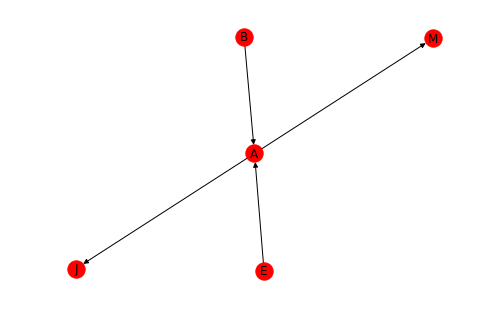

In [8]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline

N = ["B", "A", "M", "J", "E"]
E = [("B", "A"), ("E", "A"), ("A", "M"), ("A", "J")]

G = nx.DiGraph()
G.add_nodes_from(N)
G.add_edges_from(E)
nx.draw(G, with_labels=True)
plt.show()

In [9]:
# Probabilities computed from observed data.
# We know how often burglaries and earthquakes have happened, and that the alarm went off
# every time either a burglary or an earthquake happened, and finally, that Mary or John
# called when the alarm went off. All the occurances of events mentioned are recorded, and
# were used to compute their probabilities.
P = {
    "B": {
        "+b": 0.001,
        "-b": 0.999,
    },
    "E": {
        "+e": 0.002,
        "-e": 0.998,
    },
    "J|A": {
        ("+a", "+j"): 0.9,
        ("+a", "-j"): 0.1,
        ("-a", "+j"): 0.05,
        ("-a", "-j"): 0.95,
    },
    "M|A": {
        ("+a", "+m"): 0.7,
        ("+a", "-m"): 0.3,
        ("-a", "+m"): 0.01,
        ("-a", "-m"): 0.99,
    },
    "A|B,E": {
        ("+b", "+e", "+a"): 0.95,
        ("+b", "+e", "-a"): 0.05,
        ("+b", "-e", "+a"): 0.94,
        ("+b", "-e", "-a"): 0.06,
        ("-b", "+e", "+a"): 0.29,
        ("-b", "+e", "-a"): 0.71,
        ("-b", "-e", "+a"): 0.001,
        ("-b", "-e", "-a"): 0.999,
    }
}

This network, then, can be used to extract some useful information, such as posterior probability or most likely explanation, by computing joint probabilities. This process is called **inference**. For instance,

$$
\begin{align*}
P(B|+j,+m) &\propto P(B,+j,+m) \\
&= \sum_{e, a}{P(B, 3, a, +j, +m)} \\
&= \sum_{e, a}{P(B)P(e)P(a|B,e)P(+j|a)P(+m|a)}
\end{align*}
$$

which will provide another CPT for $P(B|+j,+m)$ with two entries, $P(+b|+j,+m)$ and $P(-b|+j,+m)$.

In [14]:
p0 = sum([P["B"]["+b"] * P["E"][e] * P["A|B,E"][("+b", e, a)] * P["J|A"][(a, "+j")] * P["M|A"][(a, "+m")] for e in ["+e", "-e"] for a in ["+a", "-a"]])
p1 = sum([P["B"]["-b"] * P["E"][e] * P["A|B,E"][("-b", e, a)] * P["J|A"][(a, "+j")] * P["M|A"][(a, "+m")] for e in ["+e", "-e"] for a in ["+a", "-a"]])
print("P(+b|+j,+m) =", p0)
print("P(-b|+j,+m) =", p1)

P(+b|+j,+m) = 0.0005922425899999999
P(-b|+j,+m) = 0.001491857649


This way of inference is called **inference by enumeration**. Notice how much you have to expand the equation to compute something so simple? Even with a network this small, it's apparent that this method is quite slow. We need something better.